## Just a notebook to test some pre-processing functions

Files already downloaded and verified
Files already downloaded and verified


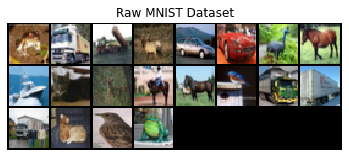

In [76]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path

PREPROCESS_PATH = './preprocess/'
DATASET_PATH = './datasets/'
DATASET = ['CIFAR10', 'MNIST'][0]

BATCH_SIZE = 664
NUM_WORKERS = 1

def show(x, title=''):
    """ Display a grid from a batched pytorch tensor.
    """
    plt.figure(frameon=False)
    img = make_grid(x)
    npimg = img.numpy()
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def select_dataset(dataset):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.flatten()),
    ])
    
    if dataset == 'CIFAR10':
        train_data = CIFAR10(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = CIFAR10(DATASET_PATH, train=False, download=True, transform=transform)
        img_shape = (3,32,32)
        show_grid = lambda x, title='': show(x.reshape(-1,3,32,32),title)
    elif dataset == 'MNIST':
        train_data = MNIST(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = MNIST(DATASET_PATH, train=False, download=True, transform=transform)
        img_shape = (1,28,28)
        show_grid = lambda x, title='': show(x.reshape(-1,1,28,28),title)
    else:
        assert False, f'{dataset} does not exist.'
        
    return train_data, test_data, show_grid

train_data, test_data, show_grid = select_dataset(DATASET)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
x = next(iter(train_loader))[0][:20]
show_grid(x, 'Raw MNIST Dataset')

preprocess_path = f'{PREPROCESS_PATH}{DATASET}'

### ZCA Whitening

**Reference: [Preprocessing for Deep Learning: From covariance matrix to image whitening
](https://www.kdnuggets.com/2018/10/preprocessing-deep-learning-covariance-matrix-image-whitening.html/3)**

**Note: Need to calculate the covariance matrix of your dataset**

Covariance Path: ./preprocess/CIFAR10.cov.npy
ZCA path: ./preprocess/CIFAR10.zca.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


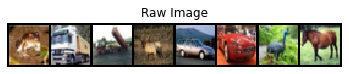

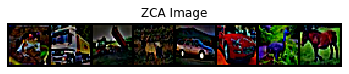

In [80]:
preprocess_path_cov = f'{preprocess_path}.cov.npy'
preprocess_path_zca = f'{preprocess_path}.zca.npy'

# Load Covariance, if it does not exist, create it.
print(f'Covariance Path: {preprocess_path_cov}')
if not Path.is_file(Path(preprocess_path_cov)):
    # Calculate Covariance
    # WARNING: This is memory intensive!
    X = []
    for x,y in iter(train_data):
        X.append(x)
    X = torch.stack(X, dim=0).numpy()
    X_cov = np.cov(X, rowvar=False)
    np.save(preprocess_path_cov, X_cov)
else:
    cov = np.load(preprocess_path_cov)

u,s,v = np.linalg.svd(cov)
epsilon = .1
W_zca = u @ np.diag(1.0/np.sqrt(s + epsilon)) @ u.T

# Store the ZCA Whitening Matrix
print(f'ZCA path: {preprocess_path_zca}')
if not Path.is_file(Path(preprocess_path_zca)):
    np.save(preprocess_path_zca, W_zca)

x = next(iter(train_loader))[0][:8]
W = torch.tensor(W_zca, dtype=torch.float32)
show_grid(x, title='Raw Image')
show_grid(x@W,title='ZCA Image')